### Assignment:

**Achieve more than 80% accuracy for CIFAR-10 classification with ConvNet .**

           

In [8]:
what_we_covering =  [
            "Describe data preparation",
            "Describe model architecture",
            "How to control overfitting?",
            "Show class(es) with the most false positive"
]

### Computer Vision and Deep Learning
คอมพิวเตอร์วิชั่นเป็นสาขาที่ใหญ่มากของปัญญาประดิษฐ์ทั้งในด้านความกว้างและความลึก
เป็นสาขาของปัญญาประดิษฐ์ที่แก้ปัญหาโดยใช้โครงข่ายประสาทเทียมระดับลึก ที่เรียกว่าการเรียนรู้เชิงลึกหรือ deep learning
ในส่วนนี้ เราจะสรุปงานพื้นฐาน 3 อย่างสั้นๆ สำหรับการใช้งานอย่างหลากหลาย

**These 3 tasks are image classification, object detection, and image segmentation.**
<br>
![](image/cv.png)

# The CIFAR-10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:
![](image/cifar-10.png)
Link here - https://www.cs.toronto.edu/~kriz/cifar.html

# 1. DATA PREPARATIOIN

In [1]:
# IMPORT LIBRARY
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

import plotly.figure_factory as ff
import plotly.graph_objects as go

from collections import Counter
from tensorflow.keras.models import load_model

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# DEFINE
NUM_CLASSES = 10
VAL_SIZE = 0.2
RANDOM_STATE = 42
BATCH_SIZE = 32

In [3]:
# LOAD DATA
(train_data, y), (test_data, y_test) = cifar10.load_data()

# CHECK SHAPE OF DATA
print(train_data.shape, y.shape, test_data.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


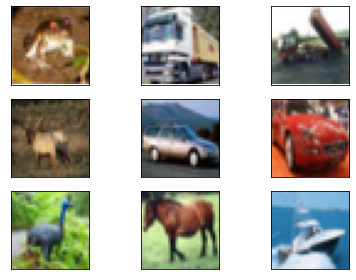

In [4]:
# SHOW IMAGE
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_data[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

ปกติค่าสีจะอยู่ในช่วง 0-255 ดังนั้นเราจะทำการแปลงค่าให้อยู่ในช่วง 0-1 เพื่อนำไป train model

In [5]:
# SCALING DATA
train_data = train_data/255.
test_data = test_data/255.

In [6]:
# CHECK LABEL
print(y.shape, y_test.shape)
y[:10]

(50000, 1) (10000, 1)


array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

**Classes**: 

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

ทำการแปลง label ให้เป็น Categorical โดยแต่ละ class จะแทนที่ด้วย 1 ถ้าไม่ใช่จะเป็น 0

In [7]:
# ONE_HOT ENCODING TO CATEGORICAL
y = to_categorical(y)
y_test = to_categorical(y_test)

print(y.shape, y_test.shape)
y[:10]

(50000, 10) (10000, 10)


array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [8]:
# SPLIT THE DATA INTO TRAIN AND VALIDATE
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, y,
                                                  test_size=VAL_SIZE,
                                                  random_state=RANDOM_STATE)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3) (40000, 10) (10000, 10)


# 2. BUILD THE MODEL (BASELINE MODEL)

"What's this Convolutional Neural Network"
- Describe.

**CNN** (Covolutional Neural Network) เป็นโครงสร้างภายใน Deep Learning Model ที่ใช้แนวคิดของ Convolution ในการทำงานกับข้อมูล 2 มิติ เช่น `Image data ซึ่งมีลักษณะเป็น Pixel` เป็นต้น

ด้วยลักษณะโครงสร้างของ CNN ที่ออกแบบมาเพื่อทำงานกับ Image Data ในตอนเริ่มต้นเราจึงสามารถแสดงข้อมูลที่เป็นองค์ประกอบของการตัดสินใจ หรือ การทำนายของ Model ด้วยภาพได้ดีกว่า Neural Network ชนิดอื่นๆ

`CNN ประกอบด้วย Kernal` และ `ผลลัพท์จากการกระทำทางคณิตศาสตร์ของ Kernel กับ Input Image` ที่เรียกว่า `Activation Map` หรือ `Feature Map `โดยทั้ง Kernel และ Feature Map นั้นแสดงผลได้ด้วยภาพ

![](image/standardcnn.png)

`2D Convolution` เป็นการนำ Matrix ขนาดเล็กของ Weight หรือที่เรียกว่า Kernel มา Slide ไปบน 2D Input Image `(สีฟ้าเข้มในภาพด้านบน)` ในขณะที่มีการทาบ Kernel บน Input Image มันจะคูณค่าแต่ละ Pixel ของ Input Image กับ Kernel แล้วนำผลลัพท์ทั้งหมดมาบวกกันเป็น 1 จุด Pixel ของ Feature Map `(สีเขียวขวามือสุด)`

2D Convolution จะมีการสร้าง Feature Map ขึ้นมาด้วยการนำ Kernel Slide ไปบน Input image จะใช้ paramete น้อยกว่า Fully Connected Layer

`ตัวอย่างการนำภาพ` ขนาด 5x5 pixels เข้า Model 2D Convolution Layer จะใช้จำนวน Parameter เท่ากับขนาดของ Kernel คือ 3 x 3 = 9 Parametes ขณะที่ถ้าเป็น Fully Conected Layer จะใช้จำนวน Parameter เท่ากัย ขนาดของ Input Image x 9 จะได้ 5 x 5 x 9 = 225 parameters

`Input Image ด้วย Padding` - ขณะที่มีการ Slide Kernel จะเห็นว่า Pixel ตรงขอบภาพสีฟ้าจะไม่มีทางอยู่ตรงกลางของ Kernel ตอนที่มันทาบลงไป เพราะเราไม่สามารถขนาย Kernel ให้เลยออกไปข้างนอกขอบของภาพได้
ดังนั้นเพื่อที่จะทำให้ Feature Map มีขนาดเท่ากับInput Image และ Pixel ที่ขอบภาพอยู่ตรงกลาง Kernel ตอนที่มันทาบลงไป เราจะต้องมีการทำ Padding โดยการเสริมกรอบด้วยการเติม 0 (zero Padding รอบๆภาพเดิม)
![](image/samepadding.gif)

`Input Image ด้วยการทำ Pooling` - การทำ Max Pooling หรือ Average Pooling เป็นวิธีหนึ่งในการลดขนาดของภาพ จะเป็นกระบวนการทำงานนอก CNN Layer จะเป็นการเลือกตัวแทนของภาพด้วยการหาค่ามากที่สุดหรือค่าเฉลี่ยจาก Pixel ใน window ตามขนาดที่กำหนด เช่น ขนาด 2x2 จะทำให้มีการลดขนาดของภาพได้ครึ่งหนึ่งตามตัวอย่าง
![](image/maxpool.gif)

`Flatten` นั้นมีไว้เพื่อแปลงข้อมูลจากภาพหลาย channel ให้เป็นเวคเตอร์ ที่สามารถส่งต่อให้ชั้นต่อไปได้ คือการแปลงข้อมูลเป็นอาร์เรย์ 1 มิติเพื่อป้อนเลเยอร์ถัดไป สมมติว่าเราได้ 5,5,5 Pooling feature map จะถูกแปลงเป็นเวกเตอร์เดียว 1x125
![](image/flatten.png)

`Dense` คือ เชื่อมแต่ละ node ทุกอัน ของชั้น layer หนึ่งไปอีก layer หนึ่ง หรือ (fully connected)

- What should the model architecture we use.

In [16]:
# BUILD THE MODEL
model = tf.keras.Sequential([
    # 1. CNN LAYER INPUT
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')    
])

Describe each layers of model:

`1st Layer Input`
โดยค่าพารามิเตอร์แรกคือ filters มีค่าเป็น 32 คือบอกว่า คือจำนวนฟิลเตอร์ทั้งหมดของเลเยอร์นี้มี 32 ชั้น พารามิเตอร์ตัวที่สองคือ kernel_size มีค่าเป็น 3x3 และ input_shape=(32, 32 ,3) คือรูปขนาด 32x32 และมี 3 channels ในนี้ก็คือ RGB, activation function เป็น relu และ padding เซ็ทไว้เป็น same  เพื่อให้ข้อมูลที่ส่งออกมีขนาดเท่าเดิม (ไม่ให้ output ที่ได้มีขนาดเล็กลง)

`2nd Layer`
ใน Layer นี้เราจะใช้ Convolution layer โดนมี filters มีค่าเป็น 32 และมี Padding = 'same' เพื่อให้ข้อมูลที่ส่งออกมีขนาดเท่าเดิม
จากนั้นเราจะใช้ Max pooling ขนาด 2x2 

`3nd Layer`
ต่อมาเราาจะใช้ Convolution  layer โดนมี filters มีค่าเป็น 64 
จากนั้นเราจะใช้ Max pooling ขนาด 2x2 

`4rd Layer`
จากนั้นเราจะใช้ Convolution Layer เหมือนเดิมโดยมี filter มีค่าเป็น 64 และ มี activation funtion เป็น relu
เราจะใช้ Max Pooling ขนาด 2x2 เหมือนเดิม

`FULLY CONNECTED Layer`
เพิ่มชั้น(Layer) ที่เป็น flatten ให้กับโมเดลเพื่อแปลงข้อมูลจากภาพให้เป็นเวคเตอร์ ที่จะสามารถส่งต่อให้ชั้นต่อไปได้ (ง่ายๆคือเอาข้อมูลอาร์เรย์ขนาดหลายมิติจากชั้นที่แล้ว มาตีแผ่ออกเหลือแค่มิติเดียว) จากนั้นจะทำการรวมเอา Output ทั้งหมดมา Activate ใน Dense layer นั่นก็คือ Layer ที่เชื่อมต่อทุก Neuron แบบปกติ ซึ่งจะมีขนาดเท่ากับ Output 256 

`OUTPUT Layer`
สุดท้ายก็ Output ออกไปยัง Softmax layer ขนาด 10 neuron เพื่อจำแนก Classification ออกเป็น 10 classes

In [17]:
# COMPILE THE MODEL
model.compile(loss='categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

Describe :
เซ็ทค่ากระบวนการเรียนรู้ให้กับโมเดลก่อนจะนำไปใช้เทรนข้อมูลด้วยฟังก์ชั่น compile 
- `Loss funtion` เป็น **categorical_crossentropy** 

เป็น Loss function ที่ใช้ในการเทรน multi-class classification model
- `Optimization Algorithm` เป็น **Adam** 

Adam ย่อมาจาก Adaptive Moment Estimation เป็นการรวม Momentum และ RMSProp (เป็น Optimizer เช่นกัน)เข้าด้วยกัน ถือว่าเป็น Optimizer ที่ดีที่สุดในปัจจุบัน
- `Metics` เป็น **accuracy**

Accuracy คือ metric ที่ใช้งานง่ายที่สุด บอกว่าโมเดลเราทำนายถูกทั้งหมดกี่ % 

In [18]:
# MODEL SUMMARY
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [19]:
# FIT THE MODEL
NO_EPOCHS = 10

history = model.fit(X_train, y_train,
                   batch_size=BATCH_SIZE,
                   epochs=NO_EPOCHS,
                   verbose=1,
                   validation_data=(X_val, y_val))

Epoch 1/10
1250/1250 [==============================] - 13s 6ms/step - loss: 1.3809 - accuracy: 0.5013 - val_loss: 1.0477 - val_accuracy: 0.6240
Epoch 2/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.9285 - accuracy: 0.6732 - val_loss: 0.8226 - val_accuracy: 0.7099
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.7346 - accuracy: 0.7414 - val_loss: 0.8107 - val_accuracy: 0.7199
Epoch 4/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5822 - accuracy: 0.7968 - val_loss: 0.7527 - val_accuracy: 0.7484
Epoch 5/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4371 - accuracy: 0.8468 - val_loss: 0.9419 - val_accuracy: 0.7107
Epoch 6/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.3187 - accuracy: 0.8882 - val_loss: 0.9404 - val_accuracy: 0.7325
Epoch 7/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.2238 - accuracy: 0.9221 - val_loss: 1.1068 - val_accuracy

In [20]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

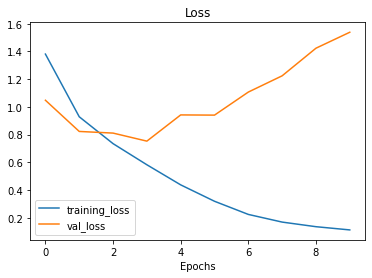

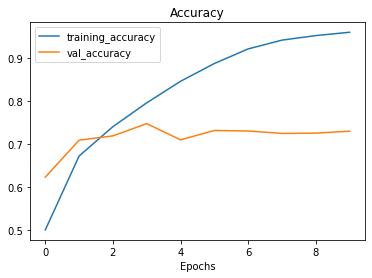

In [21]:
# VIEW THE LOSS CURVES
plot_loss_curves(history)

In [22]:
# EVALUATE THE MODEL
score = model.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 1.6215503215789795
Test Accuracy: 0.7182999849319458


จากกราฟ Loss จะพบว่า model มีปัญหา `Overfitting` ตั้งแต่แรก เมื่อวัดประสิทธิภาพในการ Predict ด้วย Test dataset ได้ค่า Accuracy 71.82%

In [24]:
# SAVE BASELINE MODEL
filepath = 'baseline-model.h5'
model.save(filepath)

# 3. TRY TO IMPROVE OVERFITTING BY IMAGE AUGMENTATION TECHNIQUE

ปัญหา `Overfitting` ของ model สามารถแก้ไขด้วยการเพิ่มจำนวน data ในการ train แต่ด้วย dataset ของเรามีจำนวนจำกัด ดังนั้น ในกรณีเราจึงต้องสังเคราะห์ data ขึ้นมาเอง ในกรณี data แบบ Image เราสามารถใช้เทคนิค `Image Augmentation` เพื่อทำการ หมุนภาพ เลื่อนภาพ กลับภาพ เป็นต้น
ซึ่งนอกจากจะเป็นการเพิ่มจำนวน data แล้ว Image Augmentation ยังช่วยเพิ่มความหลากหลายของภาพที่จะนำไป train อีกด้วย

In [88]:
# IMAGE AUGMENTATION
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=0.5, #Randomly rotate image in the range
                            zoom_range=0.2, # Randomly zoom image
                            width_shift_range=0.1, # Randomly shift images horizontally
                            height_shift_range=0.1, # Randomly shift images vertically
                             shear_range=0.5) # Random shear images
# Fit to training data
datagen.fit(X_train)

In [25]:
# DEFINE MODEL CNN
model_2 = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [26]:
# COMPILE THE MODEL
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [27]:
# MODEL SUMMARY
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [28]:
# FIT THE MODEL
NO_EPOCHS = 50

history_2 = model_2.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.5296 - accuracy: 0.4450 - val_loss: 1.1976 - val_accuracy: 0.5719
Epoch 2/50
1250/1250 [==============================] - 17s 14ms/step - loss: 1.1427 - accuracy: 0.5946 - val_loss: 0.9061 - val_accuracy: 0.6810
Epoch 3/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9704 - accuracy: 0.6592 - val_loss: 0.9073 - val_accuracy: 0.6875
Epoch 4/50
1250/1250 [==============================] - 17s 13ms/step - loss: 0.8648 - accuracy: 0.6948 - val_loss: 0.8760 - val_accuracy: 0.6997
Epoch 5/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7984 - accuracy: 0.7188 - val_loss: 0.8862 - val_accuracy: 0.7072
Epoch 6/50
1250/1250 [==============================] - 17s 14ms/step - loss: 0.7495 - accuracy: 0.7360 - val_loss: 0.7683 - val_accuracy: 0.7492
Epoch 7/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.7055 - accuracy: 0.7526 - val_loss: 0.7663 -

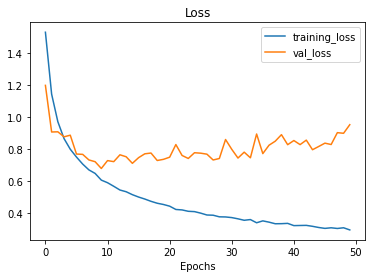

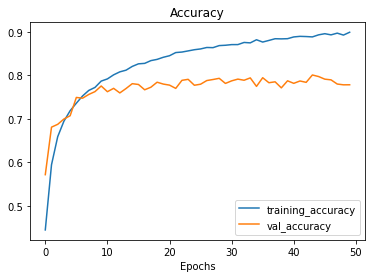

In [29]:
# PLOT LOSS CURVES
plot_loss_curves(history_2)

In [30]:
# EVALUATE THE MODEL_2
score = model_2.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.9599594473838806
Test Accuracy: 0.7718999981880188


จากกราฟ Loss ด้านบนจะเห็นว่า เมื่อมีการ Train ทั้งหมด 50 Epochs พบว่า Validation Loss ไม่พุ่งขึ้นตั้งแต่แรกๆ เหมือนในการ train แบบไม่ใช่ Image Augmentation เทคนิค เมื่อวัดประสิทธิภาพในการ Predict ด้วย Test dataset ได้ค่า `Accuracy 77.18%` แต่อย่างไรก็ตาม ในช่วงประมาณ epoch ที่ 10 Validation loss ยกสูงขึ้นอย่างเห็นได้ว่าเกิดปัญหา `Overfitting`

In [31]:
# SAVE BASELINE MODEL
filepath = 'model_2.h5'
model.save(filepath)

# 4. TRY TO IMPROVE OVERFITTING BY BATCH NORMALIZATION TECHNIQUE

`BatchNormalization` เป็นเทคนิคในการทำ `Scaling Data` หรือเรียกว่าการทำ `Normalization` เพื่อปรับค่าข้อมูลให้อยู่ในขอบเขตที่กำหนด ก่อนส่งออกจาก Node ใน Neural Network Layer เป็น Input ของ Layer ถัดไปซึ่งเดิมเราจะทำ Normalization ในขั้นตอน Feature Engineering เช่น Normalize ด้วยการแปลงค่าสีของภาพแบบ GrayScale จาก 0-255 เป็น 0-1 โดยการนำค่าสีเดิมมาหารด้วย 255 เป็นต้น

นอกจากนี้ การทำ Data Normalization กับ feature อย่างช่น อายุ และเงินเดือน จะทำให้ ทั้ง 2 feature มีน้ำหนักที่เท่ากัน มีการกระจายตัวเหมือนกัน ไม่มีตัวไหนตัวหนึ่งตัวใดมีอิทธิพลมากกว่ากันทั้งยังเป็นการเพิ่มความเร็วในการ train model และทำให้ค่า loss ลดลงเมื่อเทียบกับตอนที่ยังไม่ได้ทำ Normalization เพราะมีค่าข้อมูลที่เล็กกว่า

In [32]:
# TRY TO USE BATCH NORMALIZATION
# BUILD THE MODEL_3
model_3 = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [33]:
# COMPILE THE MODEL
model_3.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [34]:
# MODEL SUMMARY
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)       

In [35]:
# FIT THE MODEL
NO_EPOCHS = 50

history_3 = model_3.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/50
1250/1250 [==============================] - 19s 14ms/step - loss: 1.4290 - accuracy: 0.4965 - val_loss: 1.3353 - val_accuracy: 0.5466
Epoch 2/50
1250/1250 [==============================] - 18s 14ms/step - loss: 1.0503 - accuracy: 0.6308 - val_loss: 1.1055 - val_accuracy: 0.6307
Epoch 3/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.8981 - accuracy: 0.6838 - val_loss: 0.9115 - val_accuracy: 0.6890
Epoch 4/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.8059 - accuracy: 0.7185 - val_loss: 0.9516 - val_accuracy: 0.6868
Epoch 5/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.7259 - accuracy: 0.7470 - val_loss: 0.8841 - val_accuracy: 0.7113
Epoch 6/50
1250/1250 [==============================] - 19s 15ms/step - loss: 0.6694 - accuracy: 0.7663 - val_loss: 0.7455 - val_accuracy: 0.7395
Epoch 7/50
1250/1250 [==============================] - 18s 14ms/step - loss: 0.6260 - accuracy: 0.7809 - val_loss: 0.7311 -

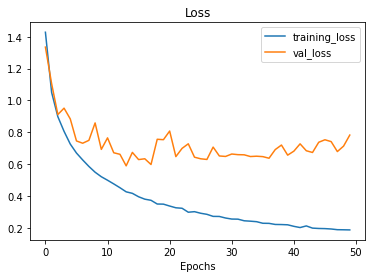

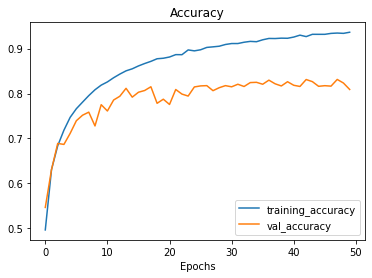

In [36]:
# VIEW THE LOSS CURVES
plot_loss_curves(history_3)

In [37]:
# EVALUATE THE MODEL_3
score = model_3.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.8087754249572754
Test Accuracy: 0.8041999936103821


จากกราฟ Loss พบว่า Training Loss มีแนวโน้มที่จะลดลง แต่ validation Loss คอนข้างแกว่งถึงแม้ว่า Accuracy จะเพิ่มขึ้นเป็น 80.41% ก็ตาม ฉะนั้นจึงอาจจะต้องใช้เทคนิคอื่นมาช่วยแก้ปัญหา `Overfitting `
ซึ่งมีเทคนิคหนึ่งที่มักนำมาใช้งานร่วมกันกับ `BatchNormalization` คือ `Dropout` เทคนิค

In [38]:
# SAVE BASELINE MODEL
filepath = 'model_3.h5'
model.save(filepath)

# 5. TRY TO IMPROVE OVERFITTING BY BATCH NORMALIZATION AND DROUPOUT TECHNIQUE

`Dropout` เป็นเทคนิคในการทำ Regularization ที่เรียบง่ายแต่มีประสิทธิภาพอย่างมาก โดยเมื่อมีการใช้งาน Dropout ภายใน Layer ที่กำหนด Node ใน Layer นั้นจะถูกสุ่มเพื่อปิดการทำงานชั่วคราวในแต่ละรอบของการทำงาน ในขณะที่ Train Model ทำให้ไม่มีการ Update Weight ใดๆ ที่ถูกเชื่อมต่อกับ Neuron Node ที่กำลังถูกปิด เราอาจจะมองการทำงานของ Dropout เหมือนกับการทำงานของบริษัทหนึ่งที่มีพนักงาน 100 คน 

- **ในกรณีที่ไม่มีการใช้** `Dropout` เปรียบได้กับการที่บริษัทมีนโยบายไม่อนุญาตให้พนักงานคนใดลาหยุดงาน ทำให้แต่ละคนต้องรับผิดชอบงานของตัวเองจนมีความเชี่ยวชาญเฉพาะด้าน สามารถแก้ปัญหาแบบเดิมๆ ที่เคยเรียนรู้มาแล้วเป็นอย่างดี แต่เมื่อเจอปัญหาใหม่ๆ พวกเขาจะไม่สามารถประยุกต์ใช้ความรู้ และทักษะความชำนาญเดิมมาแก้ปัญหาได้อย่างมีประสิทธิภาพ
- **ในกรณีที่มีการใช้** Dropout เปรียบได้กับการที่บริษัทมีนโยบายอนุญาให้พนักงานลาหยุดงานได้ ด้วยการสุ่มในอัตราที่กำหนด เช่น วันล่ะ 1 คน โดยคนที่ยังคงปฏิบัติต้องสลับกันมารับผิดชอบในหน้าที่ของพนักงานที่ได้หยุดพัก จนทำให้ทุกคนสามารถทำงานต่างๆ ทดแทนกันได้อย่างดี โดยไม่มีพนักงานคนใดมีอิทธิพลเหนือคนอื่น เมื่อเจอปัญหาใหม่ๆ พวกเขาจะสามารถประยุกต์ใช้ความรู้ และทักษะความชำนาญมาแก้ปัญหาได้อย่างมีประสิทธิภาพ
- **การใช้งานจริง** เราควรนำ Dropout มาใช้กับ `Model ที่มี Capacity สูงมากพอ` เช่นเดียวกับที่ควรนำไปใช้กับบริษัทที่มีพนักงานจำนวนมากๆ `โดยมีอัตราการ Dropout อยู่ในช่วงระหว่าง 0.2-0.5`

In [39]:
# TRY TO USE BATCH NORMALIZATION AND DROPOUT
# BUILD THE MODEL_4
model_4 = tf.keras.Sequential([
    # 1. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # 2. CNN LAYER
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    # 3. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # 4. CNN LAYER
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),
    # FULLY CONNECTED LAYER
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    # OUTPUT LAYER
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [40]:
# COMPILE THE MODEL_4
model_4.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [41]:
# SUMMARY MODEL_4
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)       

ในการ Train Model รอบนี้อยากลองเพิ่ม Epoch ในการเทรนเป็น 200 จากเดิม 50 เพราะคาดว่า Validation Loss จะลดลงได้มากกว่าก่อนใช้ Dropout.

In [42]:
# FIT THE MODEL
NO_EPOCHS = 200

history_4 = model_4.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                       shuffle=True,
                       epochs=NO_EPOCHS,
                       validation_data=(X_val, y_val),
                       verbose=1, steps_per_epoch=X_train.shape[0] // BATCH_SIZE)

Epoch 1/200
1250/1250 [==============================] - 19s 14ms/step - loss: 1.7081 - accuracy: 0.3993 - val_loss: 1.4244 - val_accuracy: 0.4960
Epoch 2/200
1250/1250 [==============================] - 18s 14ms/step - loss: 1.3326 - accuracy: 0.5209 - val_loss: 1.4112 - val_accuracy: 0.5589
Epoch 3/200
1250/1250 [==============================] - 18s 14ms/step - loss: 1.1673 - accuracy: 0.5883 - val_loss: 1.3336 - val_accuracy: 0.5817
Epoch 4/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0768 - accuracy: 0.6198 - val_loss: 1.0022 - val_accuracy: 0.6536
Epoch 5/200
1250/1250 [==============================] - 19s 15ms/step - loss: 1.0170 - accuracy: 0.6420 - val_loss: 0.9314 - val_accuracy: 0.6882
Epoch 6/200
1250/1250 [==============================] - 21s 17ms/step - loss: 0.9839 - accuracy: 0.6553 - val_loss: 0.9620 - val_accuracy: 0.6748
Epoch 7/200
1250/1250 [==============================] - 22s 17ms/step - loss: 0.9372 - accuracy: 0.6718 - val_loss: 0

1250/1250 [==============================] - 21s 17ms/step - loss: 0.4863 - accuracy: 0.8320 - val_loss: 0.5006 - val_accuracy: 0.8392
Epoch 112/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4870 - accuracy: 0.8303 - val_loss: 0.4900 - val_accuracy: 0.8439
Epoch 113/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4855 - accuracy: 0.8302 - val_loss: 0.4892 - val_accuracy: 0.8445
Epoch 114/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4798 - accuracy: 0.8314 - val_loss: 0.4988 - val_accuracy: 0.8389
Epoch 115/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4915 - accuracy: 0.8252 - val_loss: 0.4906 - val_accuracy: 0.8389
Epoch 116/200
1250/1250 [==============================] - 20s 16ms/step - loss: 0.4812 - accuracy: 0.8309 - val_loss: 0.5052 - val_accuracy: 0.8374
Epoch 117/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4767 - accuracy: 0.8329 - val_loss: 0

1250/1250 [==============================] - 18s 15ms/step - loss: 0.4475 - accuracy: 0.8428 - val_loss: 0.5108 - val_accuracy: 0.8395
Epoch 167/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4455 - accuracy: 0.8428 - val_loss: 0.4978 - val_accuracy: 0.8408
Epoch 168/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4499 - accuracy: 0.8425 - val_loss: 0.5166 - val_accuracy: 0.8336
Epoch 169/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4490 - accuracy: 0.8413 - val_loss: 0.4714 - val_accuracy: 0.8479
Epoch 170/200
1250/1250 [==============================] - 18s 14ms/step - loss: 0.4436 - accuracy: 0.8435 - val_loss: 0.4907 - val_accuracy: 0.8415
Epoch 171/200
1250/1250 [==============================] - 18s 15ms/step - loss: 0.4414 - accuracy: 0.8456 - val_loss: 0.4936 - val_accuracy: 0.8396
Epoch 172/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.4429 - accuracy: 0.8459 - val_loss: 0

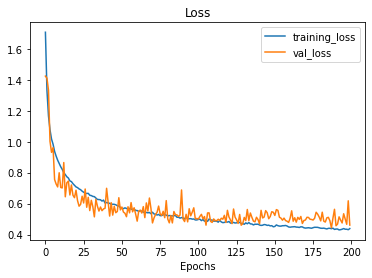

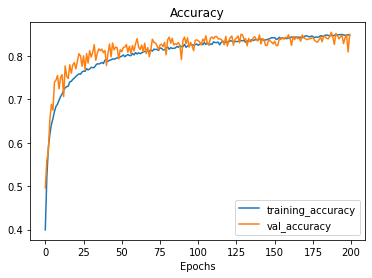

In [43]:
plot_loss_curves(history_4)

In [44]:
# EVALUATE THE MODEL_4
score = model_4.evaluate(test_data, y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.4863636791706085
Test Accuracy: 0.843999981880188


จากกราฟ Loss ด้านบน จะเห็นได้ว่าหลังจากการ Train Model ที่ 200 Epochs พบว่า Validationi Loss ไม่พุ่งขึ้นจนเกิดปัญหา Overfitting 

In [45]:
# SAVE BASELINE MODEL
filepath = 'model_4.h5'
model.save(filepath)

# 6. PREDICTION

Predict ภาพจาก Testing dataset แล้วแปลงค่าความเชื่อมั่นให้เป็นหมายเลขของ Class

In [9]:
# LOAD PREDICT MODEL
filepath = 'model_4.h5'
predict_model = load_model(filepath)
predict_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [10]:
# PREDICTION IMAGE FROM TESTING DATASET
predicted_classes = predict_model.predict(test_data)
predicted_classes

array([[5.1064090e-11, 1.0744851e-11, 5.0574592e-15, ..., 1.8457414e-13,
        1.1280791e-09, 1.4488854e-17],
       [8.0051517e-16, 2.2366622e-12, 8.0087921e-22, ..., 4.1395889e-31,
        1.0000000e+00, 5.5191843e-13],
       [5.1853222e-06, 5.1041477e-04, 7.3184196e-06, ..., 1.6945211e-09,
        9.9947566e-01, 1.0494980e-06],
       ...,
       [1.4376934e-11, 5.3418817e-19, 9.8440719e-01, ..., 3.7801225e-08,
        4.3221110e-19, 1.5900060e-16],
       [5.9897574e-03, 8.9844054e-01, 2.4766990e-03, ..., 5.1968644e-04,
        1.3240744e-14, 5.0422862e-08],
       [1.2648526e-21, 1.0712550e-18, 1.7354549e-15, ..., 1.0000000e+00,
        3.9189796e-19, 1.4464907e-23]], dtype=float32)

In [11]:
predicted_classes = np.argmax(predicted_classes, axis=1)
predicted_classes

array([3, 8, 8, ..., 2, 1, 7], dtype=int64)

แปลงผลเฉลยที่มีการเข้ารหัสแบบ One-hot encoding เป็นหมายเลขของ Class เพื่อใช้ในการสร้าง Confusion Matrix

In [12]:
y_true = np.argmax(y_test, axis=1)
y_true

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [13]:
cm = confusion_matrix(y_true, predicted_classes)
cm

array([[717,  10,  78,  30,  11,  29,  13,  10,  65,  37],
       [  9, 835,   9,  11,   6,  13,   8,   2,  21,  86],
       [ 40,   4, 617,  96,  66,  95,  39,  26,  14,   3],
       [ 12,   4,  68, 537,  42, 243,  39,  39,   6,  10],
       [  9,   3,  87,  98, 621,  65,  23,  83,   6,   5],
       [  5,   3,  34, 180,  21, 709,   8,  34,   4,   2],
       [  5,   3,  46,  88,  39,  65, 740,   5,   7,   2],
       [  7,   3,  35,  57,  33,  84,   3, 767,   5,   6],
       [ 43,  24,  15,  22,   6,  18,   4,   8, 837,  23],
       [ 15,  67,  12,  26,   2,  27,   9,  14,  25, 803]], dtype=int64)

จะเห็นว่าในแต่ละ คลาสจะมีอยู่ 1,000 ตัวอย่าง เราลองนับจำนวนข้อมูลดูว่าแต่ละ class มี 1,000 ตัวอย่างจริงมั้ย

In [14]:
c = Counter(y_true)
c

Counter({3: 1000,
         8: 1000,
         0: 1000,
         6: 1000,
         1: 1000,
         9: 1000,
         5: 1000,
         7: 1000,
         4: 1000,
         2: 1000})

ทำการ plot cunfusion matrix ด้วย `Plotly`

In [27]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def cm_plot(cm, labels):
    x = labels
    y = labels
    
    z_text = [[str(y) for y in x] for x in cm]
    fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='blues')
    
    fig.update_layout(title_text='Confusion Matrix')
    fig.add_annotation(dict(font=dict(color='black', size=13),
                           x=0.5,
                           y=-0.15,
                           showarrow=False,
                           text='Predicted Value',
                           xref='paper',
                           yref='paper'))
    
    fig.add_annotation(dict(font=dict(color='black', size=13),
                           x=-0.20,
                           y=0.5,
                           showarrow=False,
                           text='Real Value',
                           textangle=-90,
                           xref='paper',
                           yref='paper'))
    fig.update_layout(margin=dict(t=50, l=200))
    fig['layout']['yaxis']['autorange'] = 'reversed'
    fig['data'][0]['showscale'] = True
    fig.show()

In [28]:
cm_plot(cm, labels)

จากนั้นมาดูค่า `Precision`, `Recall`, `F1-score` ด้วย `Classification_report`

In [17]:
print(classification_report(y_true, predicted_classes, target_names=labels, digits=4))

              precision    recall  f1-score   support

    airplane     0.8318    0.7170    0.7701      1000
  automobile     0.8734    0.8350    0.8538      1000
        bird     0.6164    0.6170    0.6167      1000
         cat     0.4690    0.5370    0.5007      1000
        deer     0.7332    0.6210    0.6724      1000
         dog     0.5260    0.7090    0.6039      1000
        frog     0.8352    0.7400    0.7847      1000
       horse     0.7763    0.7670    0.7716      1000
        ship     0.8455    0.8370    0.8412      1000
       truck     0.8219    0.8030    0.8123      1000

    accuracy                         0.7183     10000
   macro avg     0.7329    0.7183    0.7228     10000
weighted avg     0.7329    0.7183    0.7228     10000



- `Precision`
นิยามของ Precision คือความน่าจะเป็นที่โมเดลทำนาย class ที่ถูกต้องจากการทำนาย Class ทั้งหมด 1000 ครั้ง (ผลรวมแถวบนของ confusion matrix)

- `Recall`
นิยามของ Recall คือความน่าจะเป็นที่โมเดลสามารถตรวจจับ Class จากจำนวน class ทั้งหมดในข้อมูลของเรา  (ผลรวมคอลั่มแรกของ confusion matrix)

- `F1-Score`
F1-Score คือค่าเฉลี่ยแบบ harmonic mean ระหว่าง precision และ recall ที่วัดความสามารถของโมเดล (ไม่ต้องเลือกระหว่าง precision, recall เพราะเฉลี่ยให้แล้ว)

จากนั้นเราจะ Plot `AUC curve` และคำนวณ `ROC` ของภาพแต่ละ Class ดังนั้นต้องใช้ค่าความเชื่อมั่นในแต่ละ class ในการคำนวณ `True positive rate` และ `False Positive Rate`

In [18]:
predicted_score = predict_model.predict(test_data)
predicted_score.shape, y_test.shape

((10000, 10), (10000, 10))

In [19]:
# PLOT ROC CURVE & AUC FOR 10 classes
hovertemplate = 'False Prositive Rate = %{x:.4f}<br>True Positive Rate=%{y:.4f}<br>Threshold=%{text:.4f}'

fig = go.Figure()
fig.add_shape(type='line', line=dict(dash='dash'),
             x0=0, x1=1, y0=0, y1=1)

for i in range(predicted_score.shape[1]):
    y_real = y_test[:, i]
    y_score = predicted_score[:, i]
    
    fpr, tpr, threshold = roc_curve(y_real, y_score)
    auc_score = auc(fpr, tpr)
    
    name = f"{labels[i]}, AUC={auc_score:.4f}"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines',
                            text=threshold, hovertemplate=hovertemplate))
    
fig.update_layout(title='ROC Curve and AUC',
                 xaxis_title='False Positive Rate',
                 yaxis_title='True Positive Rate')

fig.show()

AUC ย่อมาจาก “Area Under (ROC) Curve” เป็นอีกหนึ่ง metric ยอดนิยมที่ใช้กันแทบทุกงานเลย AUC มีค่าอยู่ระหว่าง 0-1 ยิ่งเข้าใกล้ 1 แปลว่าโมเดลในภาพรวมสามารถทำนายได้ดีมาก

* AUC = 0.50 ไม่ต่างอะไรกับการเดาสุ่มเลย
* AUC > 0.70 คือเกณฑ์มาตรฐานสำหรับโมเดลส่วนใหญ่
* AUC > 0.80 โมเดลทำงานได้ดี
* AUC > 0.90 โมเดลทำงานได้ดีมา

จะเห็นว่า `Class 3 (cat)` มีค่า ROC น้อยกว่า Class อื่นๆ อย่างเห็นได้ชัด ซึ่งแสดงว่า Model ของเรามีความสามารถในการแยกภาพ Class 3 ออกจาก Class อื่นๆ ได้ไม่ดีนัก ดังนั้นเราจะกรองภาพเฉพาะ Class นี้ที่ทำนายผิด มา Plot เพื่อทำความเข้าใจ

In [20]:
y_true, predicted_classes

(array([3, 8, 8, ..., 5, 1, 7], dtype=int64),
 array([3, 8, 8, ..., 2, 1, 7], dtype=int64))

In [21]:
false_predict = y_true != predicted_classes

class3 = y_true==3

false_predict_class3 = class3 & false_predict

Counter(false_predict_class3)

Counter({False: 9537, True: 463})

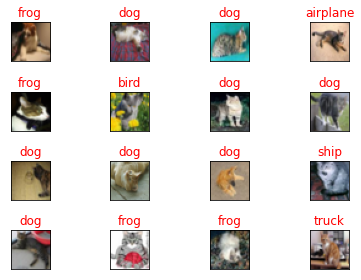

In [22]:
class3_img = test_data[false_predict_class3]
class3_y = predicted_classes[false_predict_class3]
false_predict_labels = [labels[class_num] for class_num in class3_y]

for i in range(16):
    ax = plt.subplot(4, 4, 1+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%s'%(false_predict_labels[i]), color='red')
    plt.imshow(class3_img[i], cmap=plt.get_cmap('Blues'))
plt.tight_layout()

จากภาพด้านบน Class 3 (cat) ของ Test dataset พบว่า model ทำนายผิดเป็น class ต่างๆได้แก่ frog, dog, deer และ bird
ซึ่งดูเหมือนว่าบางภาพใน Cifar-10 dataset นั้นจะถูก Label มายังไม่ถูกต้อง ดังเช่นภาพแรกของแถวที่ 2 ที่ควร Label ว่า Cat มากกว่า Frog

ในกรณีทำงานจริงๆ หากพบว่ามีการ Label ไม่ถูกต้องเป็นจำนวนมาก เราอาจต้องกลับไปแก้ไขการ Label Dataset (Train/Validate/Test) ใหม่ก่อน แล้วค่อยกลับมา Train Model ใหม่อีกครั้ง

# 7. SUMMARY

สรุป ในการทดลลองทำ `CIFAR-10 dataset` โดยการทำการสร้าง `ConvNet Model` และการแก้ปัญหา` Overfitting` โดยการทำให้ภาพมีความหลากหลายด้วยเทคนิค Image Augmentation จากนั้นทำ Regularizations เพื่อแก้ปัญหาการเกิด Overfitting ได้แก่ Batch Normalization และ Dropout โดยได้ทดลองทำ 3 แบบ คือ :
1. ใช้เฉพาะการทำ `Image Augmentation `
2. ใช้การทำ `Image Augmentation` และ `Batch Normalization`
3. ใช้การทำ `Image Augmentation` ร่วมกับ `Batch Normalization` และ `Dropout`

โดยเราสามารถดูได้จากกราฟ Loss ได้ว่า Model เกิดปัญหา Overfitting หรือไม่ ซึ่งโมเดลที่มีประสิทธิภาพดี นอกจากจะทำนาย Test Dataset ได้ค่าที่สูงแล้ว ต้องเป็นโมเดลที่ไม่เกิด `Overfitting` อีกด้วย